In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from joblib import Parallel, delayed
import math

In [2]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using the Haversine formula."""
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def process_chunk(chunk_data, tree, k_neighbors, all_prices):
    """Process a chunk of data for KNN calculations."""
    coords = np.radians(chunk_data[['latitude', 'longitude']].values)
    distances, indices = tree.query(coords, k=k_neighbors + 1)
    
    # Calculate statistics for the chunk using numpy operations
    neighbor_prices = np.take(all_prices, indices[:, 1:])
    chunk_means = np.nanmean(neighbor_prices, axis=1)
    chunk_stds = np.nanstd(neighbor_prices, axis=1)
    chunk_diffs = chunk_data['price'].values - chunk_means
    
    return {
        'knn_price_mean': chunk_means,
        'knn_price_std': chunk_stds,
        'price_diff_from_neighbors': chunk_diffs
    }

def create_spatial_features(df, k_neighbors=5, chunk_size=1000, n_jobs=-1):
    """Create spatial features with optimized KNN calculation."""
    # Paris city center coordinates
    city_center_lat, city_center_lon = 48.8566, 2.3522
    
    # Initialize spatial features DataFrame using a dictionary for better performance
    spatial_data = {
        'distance_to_center': [],
        'north_south': [],
        'knn_price_mean': [],
        'knn_price_std': [],
        'price_diff_from_neighbors': []
    }
    
    # Calculate basic distance features
    spatial_data['distance_to_center'] = df.apply(
        lambda row: calculate_distance(
            row['latitude'], 
            row['longitude'], 
            city_center_lat, 
            city_center_lon
        ),
        axis=1
    ).values
    
    # North-South position relative to city center
    spatial_data['north_south'] = (df['latitude'] - city_center_lat).values
    
    # Create BallTree once for all data
    all_coords = np.radians(df[['latitude', 'longitude']].values)
    tree = BallTree(all_coords, metric='haversine')
    all_prices = df['price'].values
    
    # Split data into chunks for parallel processing
    n_chunks = math.ceil(len(df) / chunk_size)
    chunks = np.array_split(df, n_chunks)
    
    # Process chunks in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(
            chunk, 
            tree, 
            k_neighbors,
            all_prices
        ) for chunk in chunks
    )
    
    # Combine results
    spatial_data['knn_price_mean'] = np.concatenate([r['knn_price_mean'] for r in results])
    spatial_data['knn_price_std'] = np.concatenate([r['knn_price_std'] for r in results])
    spatial_data['price_diff_from_neighbors'] = np.concatenate([r['price_diff_from_neighbors'] for r in results])
    
    # Create DataFrame from dictionary
    spatial_features = pd.DataFrame(spatial_data, index=df.index)
    
    # Standardize features
    features_to_standardize = ['distance_to_center', 'knn_price_mean', 
                             'knn_price_std', 'price_diff_from_neighbors']
    
    for col in features_to_standardize:
        spatial_features[col] = (spatial_features[col] - spatial_features[col].mean()) / spatial_features[col].std()
    
    return spatial_features

def evaluate_model_performance(y_true, y_pred, dates):
    """
    Evaluate model performance with temporal analysis.
    
    Args:
        y_true: True values
        y_pred: Predicted values
        dates: Dates for temporal analysis
    """
    results = {}
    
    # Traditional Metrics
    results['traditional'] = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    
    # Create DataFrame for analysis
    df = pd.DataFrame({
        'date': dates,
        'true': y_true,
        'pred': y_pred,
        'error': y_true - y_pred,
        'abs_error': np.abs(y_true - y_pred),
        'pct_error': np.abs((y_true - y_pred) / y_true) * 100
    })
    
    # Temporal Analysis
    monthly_metrics = df.set_index('date').resample('ME').agg({
        'abs_error': ['mean', 'std'],
        'pct_error': ['mean', 'std']
    })
    
    rolling_metrics = df.set_index('date').rolling(window=30, min_periods=1).agg({
        'abs_error': ['mean', 'std'],
        'pct_error': ['mean', 'std']
    })
    
    error_autocorr = df['error'].autocorr(lag=1)
    
    results['temporal'] = {
        'monthly_metrics': monthly_metrics,
        'rolling_metrics': rolling_metrics,
        'error_autocorr': error_autocorr
    }
    
    # Empty spatial results for plotting compatibility
    results['spatial'] = pd.DataFrame(columns=['distance_band', 'mean_error_diff', 
                                             'std_error_diff', 'n_samples'])
    
    return results

def create_evaluation_plots(results):
    """Create visualization plots for the evaluation results."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Create figure with subplots (2 or 3 depending on spatial analysis)
    has_spatial = not results['spatial'].empty
    n_plots = 3 if has_spatial else 2
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4 * n_plots))
    
    # Plot 1: Rolling Error Metrics
    rolling_metrics = results['temporal']['rolling_metrics']
    weekly_means = rolling_metrics['abs_error']['mean'].resample('W').mean()
    weekly_stds = rolling_metrics['abs_error']['std'].resample('W').mean()
    
    color = sns.color_palette("husl", 8)[0]
    sns.lineplot(x=weekly_means.index, y=weekly_means, 
                label='Weekly MAE', ax=axes[0], 
                color=color, linewidth=2)
    
    axes[0].fill_between(
        weekly_means.index,
        weekly_means - weekly_stds,
        weekly_means + weekly_stds,
        alpha=0.2,
        color=color
    )
    
    sns.despine(ax=axes[0])
    axes[0].set_title('Weekly Mean Absolute Error with Standard Deviation',
                     pad=20, fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=10)
    axes[0].set_ylabel('Error', fontsize=10)
    
    # Plot 2: Monthly Error Patterns
    monthly_data = results['temporal']['monthly_metrics']
    months = monthly_data.index.strftime('%Y-%m')
    monthly_plot_data = pd.DataFrame({
        'Month': months,
        'Mean Error': monthly_data['abs_error']['mean'],
        'Std Error': monthly_data['abs_error']['std']
    })
    
    sns.barplot(data=monthly_plot_data, 
                x='Month', 
                y='Mean Error',
                ax=axes[1],
                color=sns.color_palette("husl", 8)[1])
    
    axes[1].errorbar(x=range(len(months)), 
                    y=monthly_plot_data['Mean Error'],
                    yerr=monthly_plot_data['Std Error'],
                    fmt='none', 
                    color='black',
                    capsize=5)
    
    sns.despine(ax=axes[1])
    axes[1].set_title('Monthly Error Patterns',
                     pad=20, fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Month', fontsize=10)
    axes[1].set_ylabel('Mean Absolute Error', fontsize=10)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 3: Spatial Error Analysis (if available)
    if has_spatial:
        valid_bands = results['spatial']
        
        sns.barplot(data=valid_bands, 
                   x='distance_band', 
                   y='mean_error_diff',
                   ax=axes[2],
                   color=sns.color_palette("husl", 8)[2])
        
        axes[2].errorbar(x=range(len(valid_bands)), 
                        y=valid_bands['mean_error_diff'],
                        yerr=valid_bands['std_error_diff'],
                        fmt='none', 
                        color='black',
                        capsize=5)
        
        for i, row in valid_bands.iterrows():
            axes[2].text(i, row['mean_error_diff'], 
                        f'n={row["n_samples"]}', 
                        ha='center', va='bottom',
                        fontsize=9)
        
        sns.despine(ax=axes[2])
        axes[2].set_title('Error Differences by Distance Band',
                         pad=20, fontsize=12, fontweight='bold')
        axes[2].set_xlabel('Distance Band', fontsize=10)
        axes[2].set_ylabel('Mean Error Difference', fontsize=10)
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

In [3]:
# Load preprocessed data
print("Loading preprocessed data...")
train_data = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\train_data_2024.csv')
test_data = pd.read_csv(r'C:\Users\mvk\Documents\DATA_school\thesis\test_data_2025.csv')
print("Data loaded successfully.")

# # Reduce the number of listings to 500 for testing and development
# train_data = train_data.sample(n=1000, random_state=42)
# test_data = test_data.sample(n=500, random_state=42)
# print("Reduced the number of listings to 500 for testing and development.")

Loading preprocessed data...
Data loaded successfully.


In [4]:
# Add spatial features
print("Creating spatial features for training data...")
train_spatial = create_spatial_features(train_data)
print("Spatial features for training data created.")

print("Creating spatial features for test data...")
test_spatial = create_spatial_features(test_data)
print("Spatial features for test data created.")

# Combine with existing features
print("Combining spatial features with existing features...")
X_train = pd.concat([train_data.drop(['listing_id', 'date', 'price'], axis=1), train_spatial], axis=1)
X_test = pd.concat([test_data.drop(['listing_id', 'date', 'price'], axis=1), test_spatial], axis=1)
print("Features combined.")

y_train = train_data['price']
y_test = test_data['price']
test_dates = pd.to_datetime(test_data['date'])

Creating spatial features for training data...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Spatial features for training data created.
Creating spatial features for test data...


c:\Users\mvk\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Spatial features for test data created.
Combining spatial features with existing features...
Features combined.


In [5]:
# Initialize and train XGBoost model
print("Initializing XGBoost model...")
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.01,
    max_depth=6,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=20
)
print("XGBoost model initialized.")

# Train model
print("Training XGBoost model...")
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
print("Model training completed.")

# Make predictions
print("Making predictions on test data...")
y_pred = xgb_model.predict(X_test)
print("Predictions completed.")

Initializing XGBoost model...
XGBoost model initialized.
Training XGBoost model...
Model training completed.
Making predictions on test data...
Predictions completed.


Evaluating model performance...

=== Traditional Performance Metrics ===
R² Score: 0.9923
Mean Absolute Error: 0.0336
Root Mean Squared Error: 0.0894
Mean Absolute Percentage Error: 8.9203%

=== Temporal Analysis ===

Monthly Metrics:

Mean Absolute Error by Month:
date
2025-04-30    0.033483
2025-05-31    0.033619
Freq: ME, Name: mean, dtype: float64

Standard Deviation of Absolute Error by Month:
date
2025-04-30    0.082558
2025-05-31    0.083073
Freq: ME, Name: std, dtype: float64

Mean Percentage Error by Month:
date
2025-04-30    8.886687
2025-05-31    8.952787
Freq: ME, Name: mean, dtype: float64

Standard Deviation of Percentage Error by Month:
date
2025-04-30    38.143045
2025-05-31    38.855178
Freq: ME, Name: std, dtype: float64

Error Autocorrelation (lag=1): 0.9841

Rolling Metrics Summary (30-day window):

Mean Absolute Error Statistics:
Average: 0.0336
Min: 0.0002
Max: 3.0456

Percentage Error Statistics:
Average: 8.9203%
Min: 0.1354%
Max: 2922.4875%

Generating evaluatio

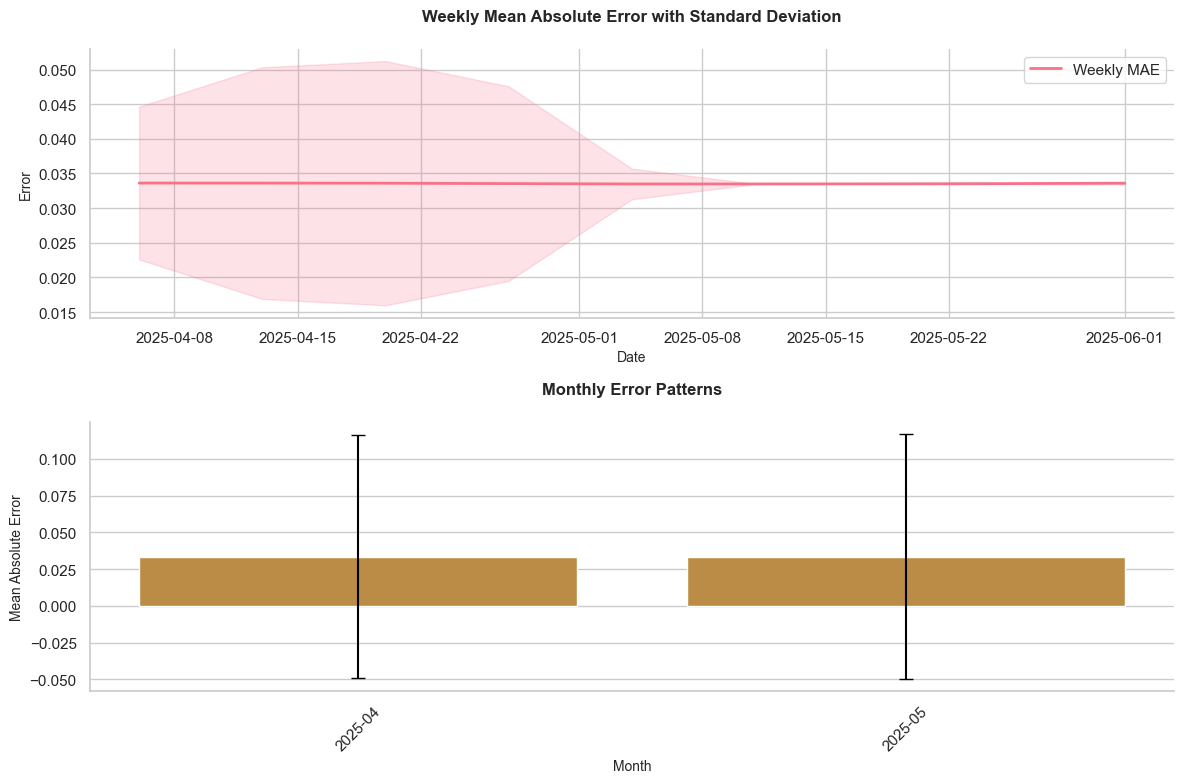


=== Feature Importance Analysis ===

Top 10 Most Important Features:
                      feature  importance
12           rolling_mean_30d    0.343728
14            rolling_max_30d    0.311519
15            rolling_min_30d    0.099294
19            rolling_min_60d    0.056806
16           rolling_mean_60d    0.049794
18            rolling_max_60d    0.039420
26             knn_price_mean    0.037869
22            rolling_max_90d    0.025307
20           rolling_mean_90d    0.009918
28  price_diff_from_neighbors    0.004616

=== Monthly Performance Breakdown ===

Detailed Monthly Performance:
              true abs_error         pct_error         
             count      mean     std      mean      std
date                                                   
2025-04-30  600000    0.0335  0.0826    8.8867  38.1430
2025-05-31  620000    0.0336  0.0831    8.9528  38.8552


In [7]:
# Main evaluation code
print("Evaluating model performance...")
evaluation_results = evaluate_model_performance(y_test, y_pred, test_dates)

# Traditional Metrics
print("\n=== Traditional Performance Metrics ===")
print(f"R² Score: {evaluation_results['traditional']['r2']:.4f}")
print(f"Mean Absolute Error: {evaluation_results['traditional']['mae']:.4f}")
print(f"Root Mean Squared Error: {evaluation_results['traditional']['rmse']:.4f}")
print(f"Mean Absolute Percentage Error: {evaluation_results['traditional']['mape']:.4f}%")

# Temporal Analysis
print("\n=== Temporal Analysis ===")
print("\nMonthly Metrics:")
monthly_metrics = evaluation_results['temporal']['monthly_metrics']
print("\nMean Absolute Error by Month:")
print(monthly_metrics['abs_error']['mean'])
print("\nStandard Deviation of Absolute Error by Month:")
print(monthly_metrics['abs_error']['std'])
print("\nMean Percentage Error by Month:")
print(monthly_metrics['pct_error']['mean'])
print("\nStandard Deviation of Percentage Error by Month:")
print(monthly_metrics['pct_error']['std'])

print(f"\nError Autocorrelation (lag=1): {evaluation_results['temporal']['error_autocorr']:.4f}")

# Rolling Metrics Summary
print("\nRolling Metrics Summary (30-day window):")
rolling_metrics = evaluation_results['temporal']['rolling_metrics']
print("\nMean Absolute Error Statistics:")
print(f"Average: {rolling_metrics['abs_error']['mean'].mean():.4f}")
print(f"Min: {rolling_metrics['abs_error']['mean'].min():.4f}")
print(f"Max: {rolling_metrics['abs_error']['mean'].max():.4f}")

print("\nPercentage Error Statistics:")
print(f"Average: {rolling_metrics['pct_error']['mean'].mean():.4f}%")
print(f"Min: {rolling_metrics['pct_error']['mean'].min():.4f}%")
print(f"Max: {rolling_metrics['pct_error']['mean'].max():.4f}%")

# Create visualization plots
print("\nGenerating evaluation plots...")
create_evaluation_plots(evaluation_results)

# Feature importance analysis
print("\n=== Feature Importance Analysis ===")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Monthly performance breakdown
print("\n=== Monthly Performance Breakdown ===")
results_df = pd.DataFrame({
    'date': test_dates,
    'true': y_test,
    'pred': y_pred,
    'abs_error': np.abs(y_test - y_pred),
    'pct_error': np.abs((y_test - y_pred) / y_test) * 100
})

# Group by month and calculate metrics
monthly_performance = results_df.set_index('date').resample('ME').agg({
    'true': 'count',
    'abs_error': ['mean', 'std'],
    'pct_error': ['mean', 'std']
}).round(4)

print("\nDetailed Monthly Performance:")
print(monthly_performance)